In [ ]:
%matplotlib inline

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from os.path import normpath, basename
from skimage import io, transform
from PIL import Image

plt.ion()   # interactive mode

In [2]:
class TextureDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        path = os.path.dirname(os.path.dirname(self.root_dir))
        self.classes = os.listdir(path)

    def __len__(self):
        lista = os.listdir(self.root_dir)
        return len(lista)

    def __getitem__(self, idx):
        lista = os.listdir(self.root_dir)
        img_name = os.path.join(self.root_dir, lista[idx])
        image = io.imread(img_name)
        img = Image.fromarray(image)
        path = os.path.dirname(self.root_dir)
        label = basename(normpath(path))
        label = self.classes.index(label)

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
    def classes(self):

        return self.classes

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

root = r'D:\Google Drive\UNICAMP\IC\KTH-TIPS\KTH-TIPS2-a'
classes = os.listdir(root)
data_dir = []
image_datasets = {'train': [] , 'val': []}

for i in range(len(classes)):
    data_dir.append(os.path.join(root,classes[i]))
    
subclasses = os.listdir(data_dir[0]) # Para que funcione, todas as classes devem ter o mesmo numero de subclasses

val_samp = 'sample_c'
train_samp = subclasses[:]
train_samp.remove(val_samp)
    
for i in range(len(classes)):
    image_datasets['val'].append(TextureDataset(os.path.join(data_dir[i], val_samp), data_transforms['val']))
    for j in range(len(train_samp)):
        image_datasets['train'].append(TextureDataset(os.path.join(data_dir[i], train_samp[j]), data_transforms['train']))

image_datasets = {x: torch.utils.data.ConcatDataset(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_datasets['train'].__getitem__(200))
print(image_datasets['val'].__getitem__(1100))
print(image_datasets['train'].__len__())
print(image_datasets['val'].__len__())

(tensor([[[ 0.4508,  0.4851,  0.4851,  ..., -1.0733, -1.0904, -1.0048],
         [ 0.4851,  0.4851,  0.4679,  ..., -1.0390, -1.0904, -1.0048],
         [ 0.4508,  0.4679,  0.4508,  ..., -1.0048, -1.0733, -1.0219],
         ...,
         [ 0.7591,  0.7762,  0.7419,  ...,  0.2967,  0.2624,  0.3823],
         [ 0.7419,  0.7591,  0.7419,  ...,  0.3138,  0.1939,  0.1939],
         [ 0.7591,  0.7591,  0.7591,  ...,  0.3309,  0.2282,  0.1768]],

        [[ 0.4503,  0.4853,  0.5028,  ..., -0.9328, -0.9503, -0.8627],
         [ 0.5203,  0.5028,  0.5028,  ..., -0.9503, -0.9678, -0.8803],
         [ 0.4853,  0.5028,  0.4853,  ..., -0.9328, -1.0028, -0.9503],
         ...,
         [ 0.7829,  0.7829,  0.8004,  ...,  0.4153,  0.3452,  0.4853],
         [ 0.8004,  0.8179,  0.8179,  ...,  0.4328,  0.2927,  0.2927],
         [ 0.8004,  0.8004,  0.8354,  ...,  0.4153,  0.2927,  0.2402]],

        [[ 0.4439,  0.4788,  0.4614,  ..., -0.7761, -0.7761, -0.6890],
         [ 0.4962,  0.4962,  0.4614,  ..., -

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



tensor([[[[ 1.1015,  0.8276,  0.2453,  ...,  0.6221,  0.0398, -0.2342],
          [ 1.1358,  0.8618,  0.2967,  ...,  0.6049,  0.0227, -0.2513],
          [ 1.1700,  0.9303,  0.3994,  ...,  0.5707, -0.0116, -0.2684],
          ...,
          [ 0.8447,  0.6734,  0.2967,  ..., -0.1143, -0.2856, -0.3541],
          [ 0.7591,  0.6221,  0.3138,  ...,  0.0741, -0.2684, -0.4054],
          [ 0.7077,  0.5878,  0.3309,  ...,  0.1768, -0.2513, -0.4397]],

         [[ 0.4153,  0.1352, -0.4601,  ...,  0.1001, -0.4951, -0.7752],
          [ 0.4153,  0.1527, -0.4251,  ...,  0.1001, -0.4951, -0.7752],
          [ 0.4328,  0.1877, -0.3725,  ...,  0.1001, -0.4951, -0.7577],
          ...,
          [ 0.1702, -0.0049, -0.3901,  ..., -0.8452, -1.0203, -1.0903],
          [ 0.1001, -0.0399, -0.3550,  ..., -0.5651, -0.9153, -1.0553],
          [ 0.0476, -0.0749, -0.3375,  ..., -0.4076, -0.8452, -1.0378]],

         [[-0.2184, -0.4973, -1.0898,  ..., -0.3578, -0.9504, -1.2293],
          [-0.2010, -0.4798, -

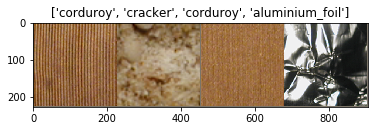

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#print (next((iter(dataloaders['train']))))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#inputs, classes = image_datasets['train'].__getitem__(200)

print (inputs)
print (classes)
print (class_names)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
#imshow(out)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9729 Acc: 0.6904
val Loss: 1.3235 Acc: 0.7104

Epoch 1/24
----------
train Loss: 0.5367 Acc: 0.8363
val Loss: 0.6981 Acc: 0.8611

Epoch 2/24
----------
train Loss: 0.4476 Acc: 0.8576
val Loss: 2.6136 Acc: 0.6894

Epoch 3/24
----------
train Loss: 0.3842 Acc: 0.8813
val Loss: 1.9388 Acc: 0.7348

Epoch 4/24
----------
train Loss: 0.2764 Acc: 0.9120
val Loss: 3.8338 Acc: 0.7660

Epoch 5/24
----------
train Loss: 0.2597 Acc: 0.9193
val Loss: 3.9613 Acc: 0.7584

Epoch 6/24
----------
train Loss: 0.2441 Acc: 0.9251
val Loss: 3.6909 Acc: 0.8443

Epoch 7/24
----------
train Loss: 0.1414 Acc: 0.9582
val Loss: 3.3318 Acc: 0.8636

Epoch 8/24
----------
train Loss: 0.1100 Acc: 0.9687
val Loss: 3.0239 Acc: 0.8064

Epoch 9/24
----------
train Loss: 0.1072 Acc: 0.9722
val Loss: 2.7575 Acc: 0.8274

Epoch 10/24
----------
train Loss: 0.1079 Acc: 0.9702
val Loss: 3.0530 Acc: 0.8173

Epoch 11/24
----------
train Loss: 0.0918 Acc: 0.9749
val Loss: 3.4804 Acc: 0.8316

Ep

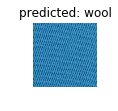

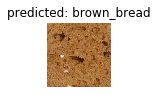

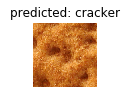

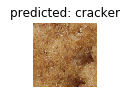

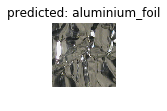

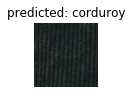

In [9]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0619 Acc: 0.6573
val Loss: 0.7977 Acc: 0.8241

Epoch 1/24
----------
train Loss: 0.7850 Acc: 0.7447
val Loss: 0.3678 Acc: 0.8763

Epoch 2/24
----------
train Loss: 0.6547 Acc: 0.7883
val Loss: 0.4049 Acc: 0.8502

Epoch 3/24
----------
train Loss: 0.6540 Acc: 0.7825
val Loss: 0.5837 Acc: 0.8013

Epoch 4/24
----------
train Loss: 0.6161 Acc: 0.7912
val Loss: 0.5739 Acc: 0.8056

Epoch 5/24
----------
train Loss: 0.6222 Acc: 0.7950
val Loss: 0.5814 Acc: 0.8106

Epoch 6/24
----------
train Loss: 0.6202 Acc: 0.8006
val Loss: 0.6938 Acc: 0.8056

Epoch 7/24
----------
train Loss: 0.5365 Acc: 0.8216
val Loss: 0.7285 Acc: 0.7727

Epoch 8/24
----------
train Loss: 0.5155 Acc: 0.8327
val Loss: 0.6315 Acc: 0.8089

Epoch 9/24
----------
train Loss: 0.5033 Acc: 0.8310
val Loss: 0.6379 Acc: 0.8098

Epoch 10/24
----------
train Loss: 0.5364 Acc: 0.8266
val Loss: 0.5858 Acc: 0.8123

Epoch 11/24
----------
train Loss: 0.4840 Acc: 0.8480
val Loss: 0.4924 Acc: 0.8359

Ep

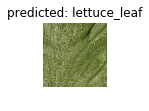

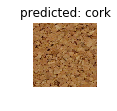

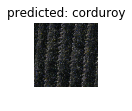

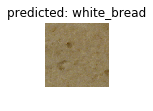

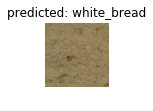

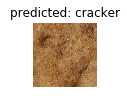

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()